## Group No

## Group Member Names:
1. SHIVAM SAHIL - 2023AA05663
2. JAHNAVI GALI - 2023AA05684
3. PRASHANT KUMAR - 2023AA05043
4. SAHIL MEHRA - 2023AA05327

In [1]:
# Install and import necessary libraries
# Example libraries: PyTorch or TensorFlow, OpenCV, NumPy, Matplotlib, etc.

import configparser
import csv
import os
import os.path as osp
import pickle

from PIL import Image
import numpy as np
import torch

# Any other setups like device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", device)


Using device: cpu


In [2]:
def get_train_directory():
    return r'mot17/MOT17/train'

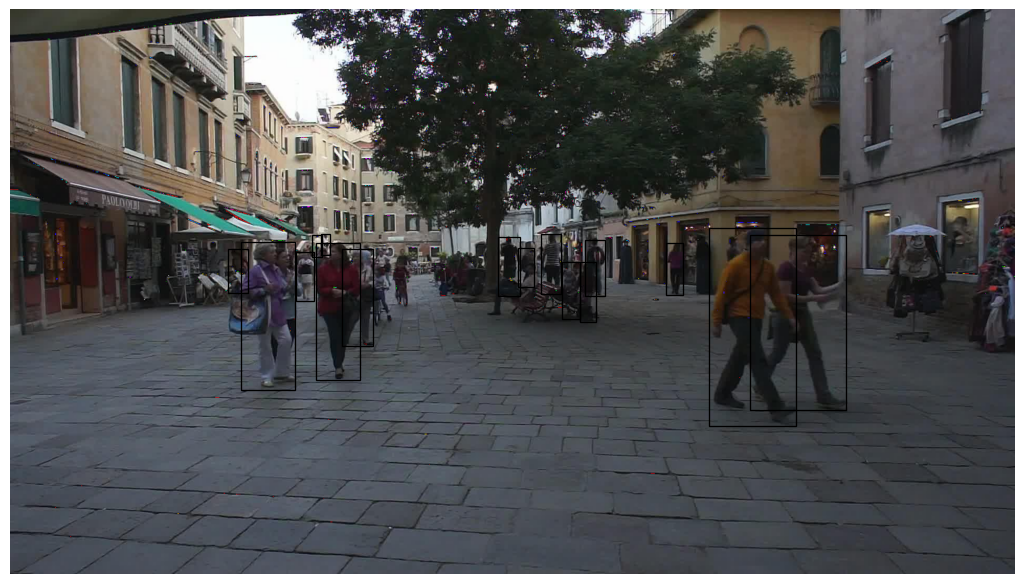

In [3]:
import matplotlib.pyplot as plt
import modules.transforms as T
from modules.object_detector import MOT17ObjDetect

# print(os.listdir('mot17/MOT17/train'))  # List the files and folders in the root directory

dataset = MOT17ObjDetect(get_train_directory())
img, target = dataset[0]

def plot(img, boxes):
    fig, ax = plt.subplots(1, dpi=96)

    # Convert tensor to NumPy
    if isinstance(img, torch.Tensor):
        img = img.mul(255).byte().cpu().numpy()  # Convert tensor to NumPy

    # Ensure shape is (H, W, C)
    if img.shape[0] == 3:  # If in (C, H, W) format
        img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C)

    # **Fix for Negative Image Issue**
    img = 255 - img  # Invert pixel values to correct the issue

    # Ensure values are in the correct range
    img = img.astype(np.uint8)

    width, height, _ = img.shape
    ax.imshow(img)
    fig.set_size_inches(width / 80, height / 80)

    # Draw bounding boxes
    for box in boxes:
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            linewidth=1.0,
            edgecolor='black'  # Make sure the color is visible
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()



img, target = T.PILToTensor().forward(img, target)
plot(img, target['boxes'])

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights



      
def get_detection_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    
    return model

In [6]:
from modules.engine import train_one_epoch, evaluate
import modules.utils as utils


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
# use our dataset and defined transformations
dataset = MOT17ObjDetect(get_train_directory(), get_transform(train=True))
dataset_no_random = MOT17ObjDetect(get_train_directory(), get_transform(train=False))
dataset_test = MOT17ObjDetect(get_train_directory(), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

num_workers = 4 # Jupyter notebook limitation
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=num_workers,
    collate_fn=utils.collate_fn)
data_loader_no_random = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=num_workers,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=num_workers,
    collate_fn=utils.collate_fn)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_detection_model(dataset.num_classes)
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

In [9]:
from tqdm import tqdm  # Make sure to install tqdm if you haven't already

def evaluate_and_write_result_files(model, data_loader):
    model.eval()
    results = {}
    # Wrap the data_loader with tqdm to display a progress bar
    for imgs, targets in tqdm(data_loader, desc="Evaluating", unit="batch"):
        imgs = [img.to(device).float()/255.0 for img in imgs]

        with torch.no_grad():
            preds = model(imgs)
        
        for pred, target in zip(preds, targets):
            results[target['image_id'].item()] = {
                'boxes': pred['boxes'].cpu(),
                'scores': pred['scores'].cpu()
            }

    data_loader.dataset.print_eval(results)
    data_loader.dataset.write_results_files(results, 'output/faster_rcnn_fpn_training_mot_17/resnet50/')

# Run the evaluation on your chosen data loader
evaluate_and_write_result_files(model, data_loader_no_random)

Evaluating: 100%|██████████| 15948/15948 [2:40:21<00:00,  1.66batch/s]   


AP: 0.02667531833909426 Prec: 0.0630548433035034 Rec: 0.3909032596652866 TP: 100554.0 FP: 1494153.0
